In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import hashlib
import collections
from sklearn.externals import joblib

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv

from data_analysis_utils import *
# from data_analysis_utils_performance import *
from data_analysis_utils_trigger_rate import *
# import supervised_classification as supc    
from utility_funtions import key_vals2val_keys

Welcome to JupyROOT 6.13/02


In [2]:
data_snippets_dir = 'trigger_rate_figures_flight_20190531'
figures_dir = os.path.join(data_snippets_dir, 'figures')
def fig_path(name, figures_dir=figures_dir):
    return os.path.join(figures_dir, name)
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [3]:
DATASETS_DICT = {}

## Flat fielded database data

In [4]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

In [5]:
common_included_columns_re_list = [
  ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
  
  'gtu_datetime_(mean|min|max)',  
  'gps_datetime_(mean|min|max)', 'gps_alt_mean', 'gps_lon_mean', 'gps_lat_mean', 
    
  ('^trg(_box_per_gtu|_pmt_per_gtu|_ec_per_gtu)?$', '^(count_nonzero|min|max|sum|mean|size)$'),
  ('^(bg|orig)(_x_y)?$','^(mean_gz|mean|max|min|sum)$'),
    
#   '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr2_max_clu_major_line_phi',
    
]

In [6]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_gps_lat
	- mean

spb_processing_v4_flatmap.event_gps_lon
	- mean

spb_processing_v4_flatmap.event_gps_alt
	- mean

spb_processing_v4_flatmap.event_gps_datetime
	- max
	- min
	- mean

spb_processing_v4_flatmap.event_gtu_datetime
	- max
	- min
	- mean

spb_processing_v4_flatmap.event_orig_x_y
	- sum
	- min
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_bg_x_y
	- sum
	- min
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg
	- count_nonzero
	- sum
	- min
	- max
	- mean
	- size

spb_processing_v4_fla

In [7]:
flight_df_columns = query_functions_flight.get_dataframe_columns_from_dict(flight_columns_for_analysis_dict)

### Flat-fielded and bgf=0.5 from database

In [8]:
unl_flight_flatmap_bgf05_key = 'unl_flight_flatmap_bgf05'

In [9]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_source_data_type_num = 1

unl_flight_where_clauses_str = ''' 
''' 

unl_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_source_data_type_num,
        select_additional=unl_flight_select_clause_str, 
        join_additional=unl_flight_clauses_str,
        where_additional=unl_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
#         limit=20000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
        limit=500000,
        base_select='')

# print(unl_flight_events_selection_query)

DATASETS_DICT[unl_flight_flatmap_bgf05_key] = {
    'df': psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)
}

In [10]:
len(DATASETS_DICT[unl_flight_flatmap_bgf05_key]['df'])

243622

In [11]:
# DATASETS_DICT[unl_flight_flatmap_bgf05_key]['by_datetime_df'] = \
#     DATASETS_DICT[unl_flight_flatmap_bgf05_key]['df'].sort_values('gtu_datetime_min', ascending=True)

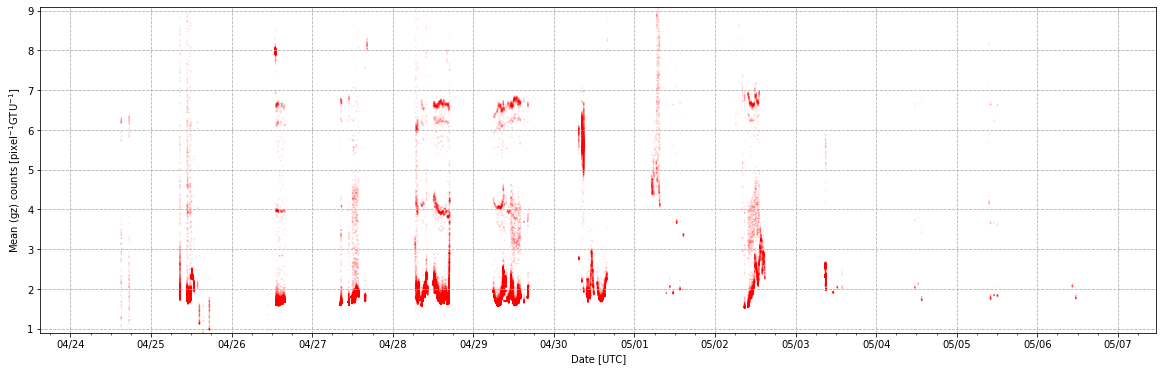

In [12]:
vis_trigger_rate(
    DATASETS_DICT[unl_flight_flatmap_bgf05_key]['df']['gps_datetime_min'].tolist(), 
    DATASETS_DICT[unl_flight_flatmap_bgf05_key]['df']['orig_mean_gz'].tolist(), 
    None,
    ax=None, show=True, ylabel='Mean (gz) counts [pixel$^{-1}$GTU$^{-1}$]',
    marker='.', alpha=.1, color='red', s=10, label=None, yscale='linear',
    ylim=(1,9),
    base_figure_pathname=fig_path('unl_flight_flatmap_bgf05_mean_counts')
#     ylim=(unl_flight_df__by_datetime['orig_mean_gz'].min(), 
#           unl_flight_df__by_datetime['orig_mean_gz'].quantile(q=0.997))
);

In [13]:
trigger_datetime_list, trigger_rate_list = \
    count_trigger_rate_per_file_from_df(DATASETS_DICT[unl_flight_flatmap_bgf05_key]['df'],  one_trg_per='packet')

DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_datetime_list'] = trigger_datetime_list
DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_rate_list'] = trigger_rate_list

1/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root
2/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root
3/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root
4/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root
5/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root
6/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150228-005.001--LONG.root
7/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root
8/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172427-001.001--LONG.root
9/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172427-002.001--LONG.root
10/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172427-003.001--LONG.root
11/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172427-004.001--LONG.root
12/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172427-005.001--LONG.root
13/1038 allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root
14/1038 allpackets-SPBEUSO-ACQUISITION-20170

112/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-006.001--LONG-sqz.root
113/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-007.001--LONG-sqz.root
114/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-008.001--LONG-sqz.root
115/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-008.001--LONG.root
116/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-010.001--LONG-sqz.root
117/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-010.001--LONG.root
118/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-011.001--LONG-sqz.root
119/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105115-001.001--CHECK.root
120/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105159-001.001--LONG-sqz.root
121/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105159-002.001--LONG-sqz.root
122/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105159-003.001--LONG-sqz.root
123/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105159-004.001--LONG-sqz.root
124/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105159-005.001

218/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-017.001--LONG-sqz.root
219/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-018.001--LONG-sqz-dis.root
220/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-018.001--LONG-sqz.root
221/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-019.001--LONG-sqz-dis.root
222/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-019.001--LONG-sqz.root
223/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-020.001--LONG-sqz-dis.root
224/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-020.001--LONG-sqz.root
225/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-021.001--LONG-sqz-dis.root
226/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-021.001--LONG-sqz.root
227/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-022.001--LONG-sqz-dis.root
228/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-022.001--LONG-sqz.root
229/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-023.001--LONG-sqz-dis.root
230/1038 allpackets-SPBEUSO-

325/1038 allpackets-SPBEUSO-ACQUISITION-20170428-120707-021.001--LONG.root
326/1038 allpackets-SPBEUSO-ACQUISITION-20170428-120707-022.001--LONG.root
327/1038 allpackets-SPBEUSO-ACQUISITION-20170428-120707-023.001--LONG.root
328/1038 allpackets-SPBEUSO-ACQUISITION-20170428-120707-024.001--LONG.root
329/1038 allpackets-SPBEUSO-ACQUISITION-20170428-120707-025.001--LONG.root
330/1038 allpackets-SPBEUSO-ACQUISITION-20170428-120707-026.001--LONG.root
331/1038 allpackets-SPBEUSO-ACQUISITION-20170428-120707-027.001--LONG.root
332/1038 allpackets-SPBEUSO-ACQUISITION-20170428-120707-028.001--LONG.root
333/1038 allpackets-SPBEUSO-ACQUISITION-20170428-120707-029.001--LONG.root
334/1038 allpackets-SPBEUSO-ACQUISITION-20170428-120707-030.001--LONG.root
335/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130727-001.001--CHECK.root
336/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-001.001--LONG.root
337/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-002.001--LONG.root
338/1038 allpackets-SPBE

435/1038 allpackets-SPBEUSO-ACQUISITION-20170429-055842-001.001--CHECK.root
436/1038 allpackets-SPBEUSO-ACQUISITION-20170429-055927-001.001--LONG.root
437/1038 allpackets-SPBEUSO-ACQUISITION-20170429-055927-007.001--LONG.root
438/1038 allpackets-SPBEUSO-ACQUISITION-20170429-055927-010.001--LONG.root
439/1038 allpackets-SPBEUSO-ACQUISITION-20170429-055927-014.001--LONG.root
440/1038 allpackets-SPBEUSO-ACQUISITION-20170429-055927-019.001--LONG.root
441/1038 allpackets-SPBEUSO-ACQUISITION-20170429-055927-024.001--LONG.root
442/1038 allpackets-SPBEUSO-ACQUISITION-20170429-065947-001.001--CHECK.root
443/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-003.001--LONG.root
444/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-004.001--LONG.root
445/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-006.001--LONG.root
446/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-008.001--LONG.root
447/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-009.001--LONG.root
448/1038 allpackets-SPB

555/1038 allpackets-SPBEUSO-ACQUISITION-20170429-110448-025.001--LONG-sqz.root
556/1038 allpackets-SPBEUSO-ACQUISITION-20170429-110448-025.001--LONG.root
557/1038 allpackets-SPBEUSO-ACQUISITION-20170429-110448-026.001--LONG-sqz.root
558/1038 allpackets-SPBEUSO-ACQUISITION-20170429-110448-027.001--LONG-sqz.root
559/1038 allpackets-SPBEUSO-ACQUISITION-20170429-110448-028.001--LONG-sqz.root
560/1038 allpackets-SPBEUSO-ACQUISITION-20170429-110448-029.001--LONG-sqz.root
561/1038 allpackets-SPBEUSO-ACQUISITION-20170429-110448-030.001--LONG-sqz.root
562/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120509-001.001--CHECK.root
563/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-001.001--LONG-sqz.root
564/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-002.001--LONG-sqz.root
565/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-002.001--LONG.root
566/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-003.001--LONG-sqz.root
567/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-004.001

661/1038 allpackets-SPBEUSO-ACQUISITION-20170430-095101-023.001--LONG-sqz.root
662/1038 allpackets-SPBEUSO-ACQUISITION-20170430-095101-024.001--LONG-sqz.root
663/1038 allpackets-SPBEUSO-ACQUISITION-20170430-095101-025.001--LONG-sqz.root
664/1038 allpackets-SPBEUSO-ACQUISITION-20170430-095101-026.001--LONG-sqz.root
665/1038 allpackets-SPBEUSO-ACQUISITION-20170430-095101-027.001--LONG-sqz.root
666/1038 allpackets-SPBEUSO-ACQUISITION-20170430-095101-028.001--LONG-sqz.root
667/1038 allpackets-SPBEUSO-ACQUISITION-20170430-095101-029.001--LONG-sqz.root
668/1038 allpackets-SPBEUSO-ACQUISITION-20170430-095101-030.001--LONG-sqz.root
669/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105121-001.001--CHECK.root
670/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-001.001--LONG-sqz.root
671/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-002.001--LONG-sqz.root
672/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-003.001--LONG-sqz.root
673/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205

796/1038 allpackets-SPBEUSO-ACQUISITION-20170501-050224-007.001--LONG-sqz.root
797/1038 allpackets-SPBEUSO-ACQUISITION-20170501-050224-008.001--LONG-sqz.root
798/1038 allpackets-SPBEUSO-ACQUISITION-20170501-050224-009.001--LONG-sqz.root
799/1038 allpackets-SPBEUSO-ACQUISITION-20170501-050224-010.001--LONG-sqz.root
800/1038 allpackets-SPBEUSO-ACQUISITION-20170501-052308-001.001--CHECK.root
801/1038 allpackets-SPBEUSO-ACQUISITION-20170501-052352-001.001--LONG-sqz.root
802/1038 allpackets-SPBEUSO-ACQUISITION-20170501-052352-002.001--LONG-sqz.root
803/1038 allpackets-SPBEUSO-ACQUISITION-20170501-052352-003.001--LONG-sqz.root
804/1038 allpackets-SPBEUSO-ACQUISITION-20170501-052352-004.001--LONG-sqz.root
805/1038 allpackets-SPBEUSO-ACQUISITION-20170501-052352-005.001--LONG-sqz.root
806/1038 allpackets-SPBEUSO-ACQUISITION-20170501-053624-001.001--LONG-sqz.root
807/1038 allpackets-SPBEUSO-ACQUISITION-20170501-053624-002.001--LONG-sqz.root
808/1038 allpackets-SPBEUSO-ACQUISITION-20170501-053624

902/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-003.001--LONG-sqz.root
903/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-004.001--LONG-sqz.root
904/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-005.001--LONG-sqz.root
905/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-006.001--LONG-sqz.root
906/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-007.001--LONG-sqz.root
907/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-008.001--LONG-sqz.root
908/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-009.001--LONG-sqz.root
909/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-010.001--LONG-sqz.root
910/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-011.001--LONG-sqz.root
911/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-012.001--LONG-sqz.root
912/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-013.001--LONG-sqz.root
913/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104613-014.001--LONG-sqz.root
914/1038 allpackets-SPBEUSO-ACQUISITION-20170502-104

1009/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-018.001--LONG-sqz.root
1010/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-019.001--LONG-sqz.root
1011/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-020.001--LONG-sqz.root
1012/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-021.001--LONG-sqz.root
1013/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-022.001--LONG-sqz.root
1014/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-023.001--LONG-sqz.root
1015/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-024.001--LONG-sqz.root
1016/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-025.001--LONG-sqz.root
1017/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-026.001--LONG-sqz.root
1018/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-027.001--LONG-sqz.root
1019/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-028.001--LONG-sqz.root
1020/1038 allpackets-SPBEUSO-ACQUISITION-20170502-134901-029.001--LONG-sqz.root
1021/1038 allpackets-SPBEUSO-ACQUISITION

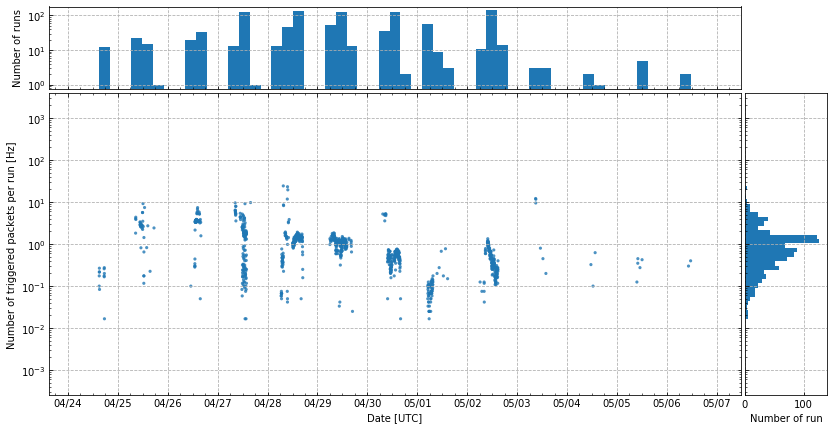

In [14]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_datetime_list'], 
    DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_rate_list'], 
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path('unl_flight_flatmap_bgf05_trg_rate_1_per_packet')
#     ylim=(DATASETS_DICT[unl_flight_flatmap_bgf05_key]['by_datetime_df'].min(), 
#           DATASETS_DICT[unl_flight_flatmap_bgf05_key]['by_datetime_df'].quantile(q=0.997))
);

### Flat-fielded and bgf=1.0 from database

In [15]:
unl_flight_flatmap_bgf1_key = 'unl_flight_flatmap_bgf1'

In [16]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_source_data_type_num = 8

unl_flight_where_clauses_str = ''' 
''' 

unl_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_source_data_type_num,
        select_additional=unl_flight_select_clause_str, 
        join_additional=unl_flight_clauses_str,
        where_additional=unl_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
#         limit=20000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
        limit=500000,
        base_select='')

# print(unl_flight_events_selection_query)


DATASETS_DICT[unl_flight_flatmap_bgf1_key] = {
    'df': psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)
}

In [17]:
len(DATASETS_DICT[unl_flight_flatmap_bgf1_key]['df'])

90587

In [18]:
# DATASETS_DICT[unl_flight_flatmap_bgf1_key]['by_datetime_df'] = \
#     DATASETS_DICT[unl_flight_flatmap_bgf1_key]['df'].sort_values('gtu_datetime_min', ascending=True)

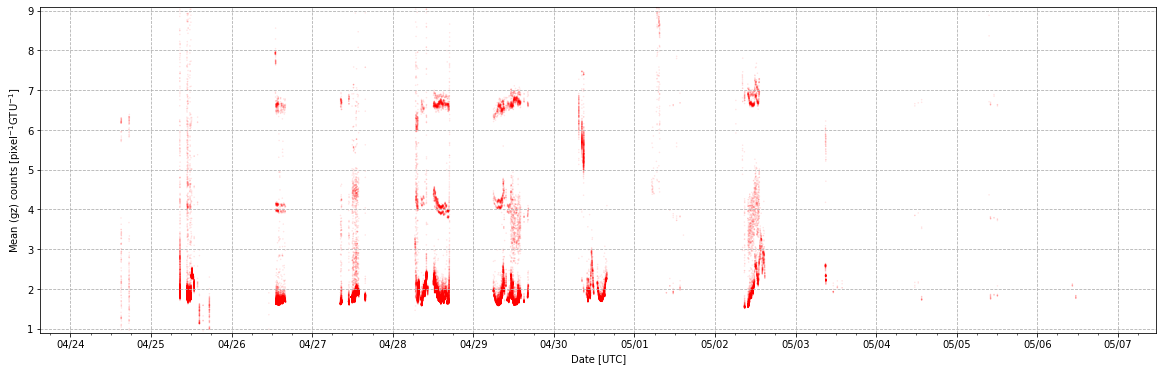

In [19]:
vis_trigger_rate(
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['df']['gps_datetime_min'].tolist(), 
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['df']['orig_mean_gz'].tolist(), 
    None,
    ax=None, show=True, ylabel='Mean (gz) counts [pixel$^{-1}$GTU$^{-1}$]',
    marker='.', alpha=.1, color='red', s=10, label=None, yscale='linear',
    ylim=(1,9),
    base_figure_pathname=fig_path('unl_flight_flatmap_bgf1_mean_counts')
#     ylim=(unl_flight_df__by_datetime['orig_mean_gz'].min(), 
#           unl_flight_df__by_datetime['orig_mean_gz'].quantile(q=0.997))
)

In [20]:
trigger_datetime_list, trigger_rate_list = \
    count_trigger_rate_per_file_from_df(DATASETS_DICT[unl_flight_flatmap_bgf1_key]['df'],  one_trg_per='packet')

DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'] = trigger_datetime_list
DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'] = trigger_rate_list

1/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root
2/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root
3/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root
4/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root
5/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root
6/1025 allpackets-SPBEUSO-ACQUISITION-20170424-150228-005.001--LONG.root
7/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root
8/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172427-001.001--LONG.root
9/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172427-002.001--LONG.root
10/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172427-003.001--LONG.root
11/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172427-004.001--LONG.root
12/1025 allpackets-SPBEUSO-ACQUISITION-20170424-172427-005.001--LONG.root
13/1025 allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root
14/1025 allpackets-SPBEUSO-ACQUISITION-20170

115/1025 allpackets-SPBEUSO-ACQUISITION-20170427-082554-008.001--LONG.root
116/1025 allpackets-SPBEUSO-ACQUISITION-20170427-082554-010.001--LONG-sqz.root
117/1025 allpackets-SPBEUSO-ACQUISITION-20170427-082554-010.001--LONG.root
118/1025 allpackets-SPBEUSO-ACQUISITION-20170427-082554-011.001--LONG-sqz.root
119/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105115-001.001--CHECK.root
120/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-001.001--LONG-sqz.root
121/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-002.001--LONG-sqz.root
122/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-003.001--LONG-sqz.root
123/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-004.001--LONG-sqz.root
124/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-005.001--LONG-sqz.root
125/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-025.001--LONG-sqz-dis.root
126/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-025.001--LONG-sqz.root
127/1025 allpackets-SPBEUSO-ACQUISITION-20170427-105159-029

235/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-023.001--LONG-sqz.root
236/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-024.001--LONG-sqz-dis.root
237/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-024.001--LONG-sqz.root
238/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-025.001--LONG-sqz-dis.root
239/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-025.001--LONG-sqz.root
240/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-026.001--LONG-sqz-dis.root
241/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-026.001--LONG-sqz.root
242/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-027.001--LONG-sqz-dis.root
243/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-028.001--LONG-sqz-dis.root
244/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-028.001--LONG-sqz.root
245/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-029.001--LONG-sqz-dis.root
246/1025 allpackets-SPBEUSO-ACQUISITION-20170427-125407-029.001--LONG-sqz.root
247/1025 allpackets-SPBEUSO-

347/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-008.001--LONG.root
348/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-009.001--LONG.root
349/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-010.001--LONG.root
350/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-011.001--LONG.root
351/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-012.001--LONG.root
352/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-013.001--LONG.root
353/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-014.001--LONG.root
354/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-015.001--LONG.root
355/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-016.001--LONG.root
356/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-017.001--LONG.root
357/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-018.001--LONG.root
358/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-019.001--LONG.root
359/1025 allpackets-SPBEUSO-ACQUISITION-20170428-130811-020.001--LONG.root
360/1025 allpackets-SPBEU

470/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-004.001--LONG.root
471/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-005.001--LONG.root
472/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-006.001--LONG.root
473/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-007.001--LONG.root
474/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-008.001--LONG.root
475/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-009.001--LONG.root
476/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-010.001--LONG.root
477/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-011.001--LONG.root
478/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-012.001--LONG.root
479/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-013.001--LONG.root
480/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-014.001--LONG.root
481/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-015.001--LONG.root
482/1025 allpackets-SPBEUSO-ACQUISITION-20170429-080135-016.001--LONG.root
483/1025 allpackets-SPBEU

589/1025 allpackets-SPBEUSO-ACQUISITION-20170429-120553-030.001--LONG-sqz.root
590/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130613-001.001--CHECK.root
591/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657-001.001--LONG-sqz.root
592/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657-002.001--LONG-sqz.root
593/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657-003.001--LONG-sqz.root
594/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657-004.001--LONG-sqz.root
595/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657-005.001--LONG-sqz.root
596/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657-006.001--LONG-sqz.root
597/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657-007.001--LONG-sqz.root
598/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657-008.001--LONG-sqz.root
599/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657-009.001--LONG-sqz.root
600/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657-010.001--LONG-sqz.root
601/1025 allpackets-SPBEUSO-ACQUISITION-20170429-130657

733/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-010.001--LONG-sqz.root
734/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-011.001--LONG-sqz.root
735/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-012.001--LONG-sqz.root
736/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-013.001--LONG-sqz.root
737/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-014.001--LONG-sqz.root
738/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-016.001--LONG-sqz.root
739/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-017.001--LONG-sqz.root
740/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-018.001--LONG-sqz.root
741/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-019.001--LONG-sqz.root
742/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-020.001--LONG-sqz.root
743/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-021.001--LONG-sqz.root
744/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133603-022.001--LONG-sqz.root
745/1025 allpackets-SPBEUSO-ACQUISITION-20170430-133

858/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-003.001--LONG-sqz.root
859/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-004.001--LONG-sqz.root
860/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-005.001--LONG-sqz.root
861/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-006.001--LONG-sqz.root
862/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-007.001--LONG-sqz.root
863/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-008.001--LONG-sqz.root
864/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-009.001--LONG-sqz.root
865/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-010.001--LONG-sqz.root
866/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-011.001--LONG-sqz.root
867/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-012.001--LONG-sqz.root
868/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-013.001--LONG-sqz.root
869/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094518-014.001--LONG-sqz.root
870/1025 allpackets-SPBEUSO-ACQUISITION-20170502-094

992/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-014.001--LONG-sqz.root
993/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-015.001--LONG-sqz.root
994/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-016.001--LONG-sqz.root
995/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-017.001--LONG-sqz.root
996/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-018.001--LONG-sqz.root
997/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-019.001--LONG-sqz.root
998/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-020.001--LONG-sqz.root
999/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-021.001--LONG-sqz.root
1000/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-022.001--LONG-sqz.root
1001/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-023.001--LONG-sqz.root
1002/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-024.001--LONG-sqz.root
1003/1025 allpackets-SPBEUSO-ACQUISITION-20170502-134901-025.001--LONG-sqz.root
1004/1025 allpackets-SPBEUSO-ACQUISITION-2017050

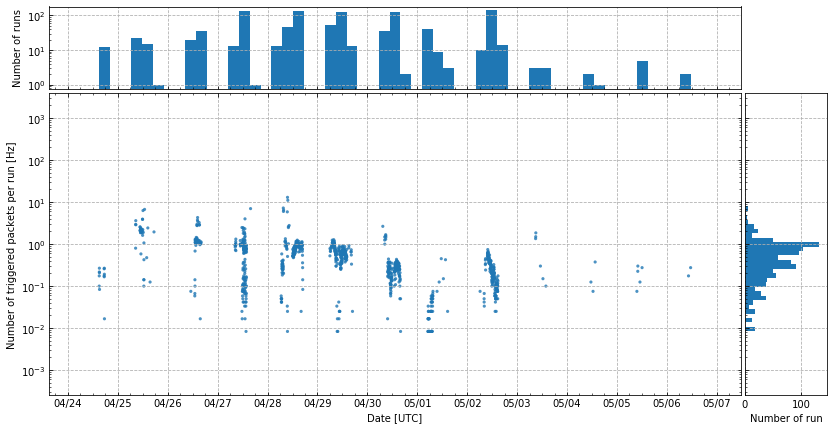

In [21]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'], 
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'],
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path('unl_flight_flatmap_bgf1_trg_rate_1_per_packet'),
);

### Comparison of trigger rates between $\textrm{bgf}=0.5$ and $\textrm{bgf}=1$

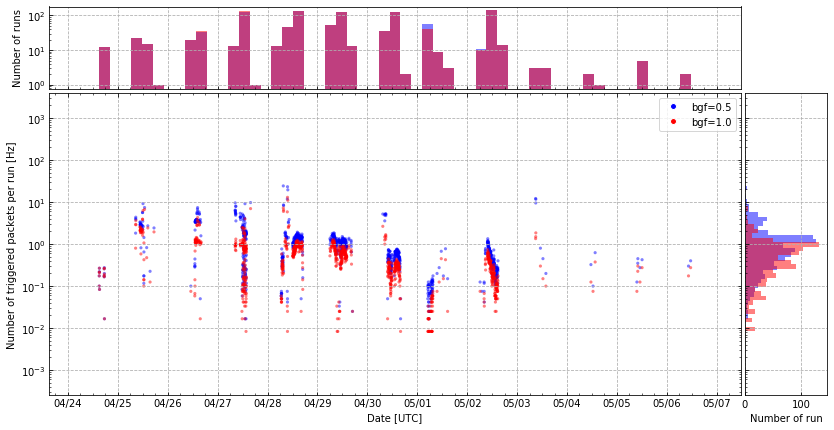

In [22]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_datetime_list'], 
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_rate_list'], 
        ylim=(10**(-2.5), 10**(2.5)),
        label='bgf=0.5', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'], 
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'],
    ylim=(10**(-2.5), 10**(2.5)), 
    label='bgf=1.0',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_bgf05_and_bgf1_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True,
    show=True
);

## Trigger rates from l1trg (TrigVisKenji) with default $P$, $R$ configuration

### $\textrm{bgf}=0.5$ with flat field map

In [23]:
l1trg_files_bgf05_with_flatmap_key = 'l1trg_files_bgf05_with_flatmap'

In [24]:
#!cat trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_info.txt

In [25]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('trigger_rate_for_l1trg/bgf05_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key] = {'lists_df': df}

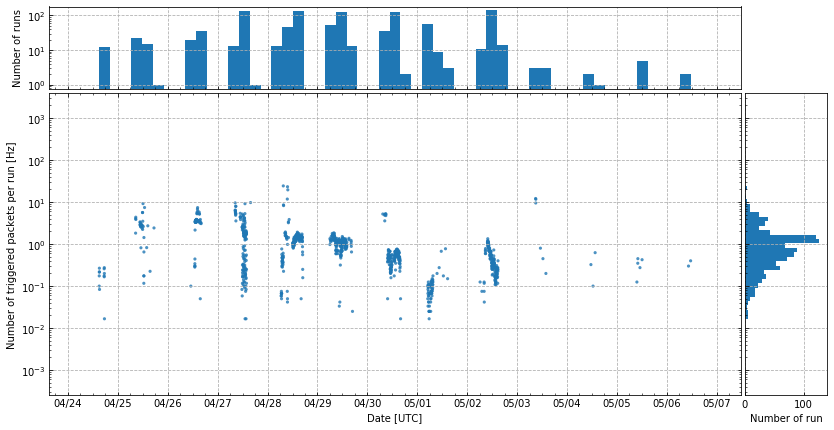

In [26]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf05_with_flatmap_key + '_trg_rate_1_per_packet')
);

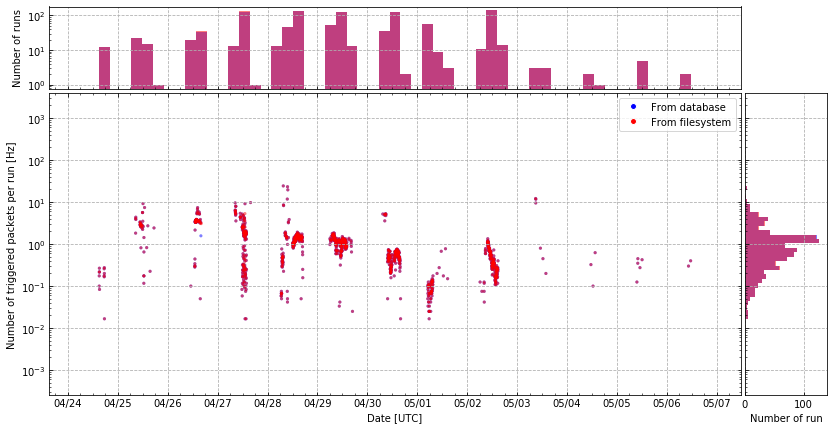

In [27]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_datetime_list'], 
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_rate_list'], 
        ylim=(10**(-2.5), 10**(2.5)),
        label='From database', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='From filesystem',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_db_bgf05_and_l1trg_bgf05_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True,
    show=True
);

### $\textrm{bgf}=0.5$ without flat field map

In [28]:
#!cat trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_info.txt

In [29]:
l1trg_files_bgf05_no_flatmap_key = 'l1trg_files_bgf05_no_flatmap'

In [30]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('trigger_rate_for_l1trg/bgf05_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key] = {'lists_df': df}

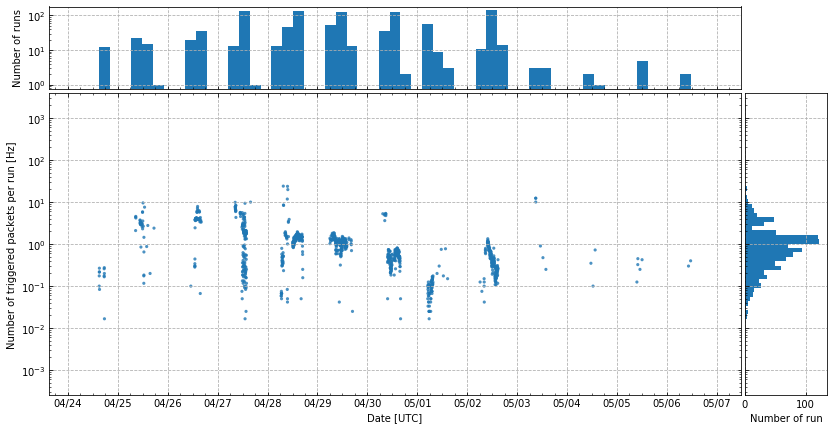

In [31]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf05_no_flatmap_key + '_trg_rate_1_per_packet')
);

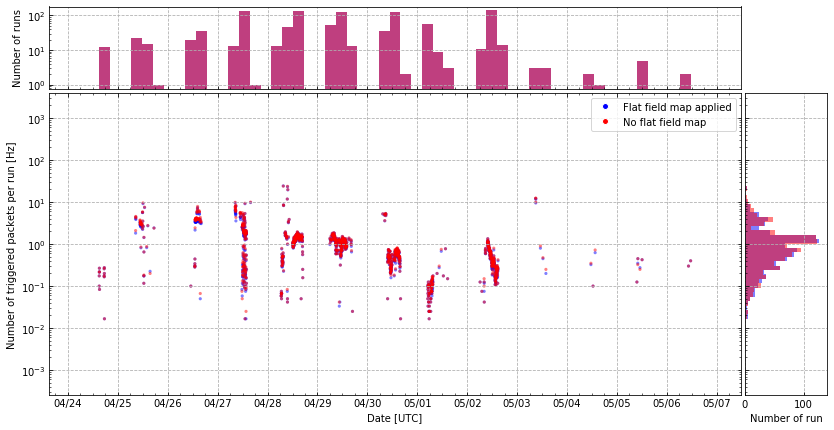

In [32]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf05_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='Flat field map applied', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf05_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='No flat field map',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_l1trg_bgf05_flatmap_yes_no_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True,
    show=True
);

### $\textrm{bgf}=1$ with flat field map

In [33]:
#!trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_info.txt

In [34]:
l1trg_files_bgf1_with_flatmap_key = 'l1trg_files_bgf1_with_flatmap'

In [35]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('trigger_rate_for_l1trg/bgf1_with_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key] = {'lists_df': df}

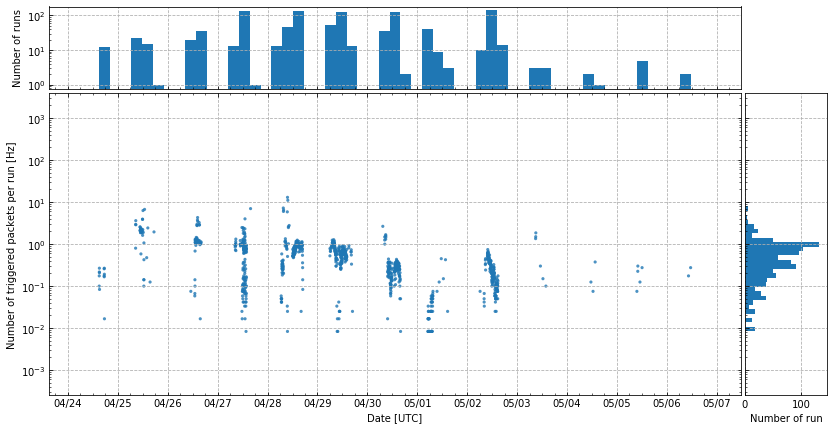

In [36]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf1_with_flatmap_key + '_trg_rate_1_per_packet')
);

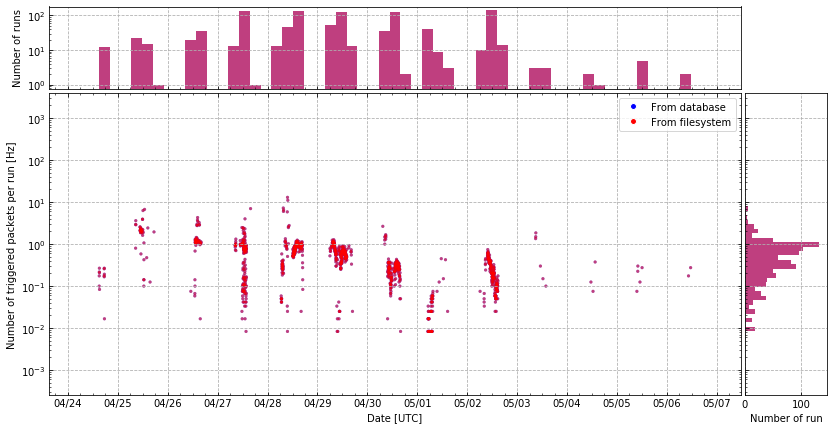

In [37]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'], 
        DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'], 
        ylim=(10**(-2.5), 10**(2.5)),
        label='From database', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='From filesystem',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_db_bgf1_and_l1trg_bgf1_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True,
    show=True
);

### $\textrm{bgf}=1$ without flat field map

In [38]:
l1trg_files_bgf1_no_flatmap_key = 'l1trg_files_bgf1_no_flatmap'

In [39]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('trigger_rate_for_l1trg/bgf1_no_flatmap2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')


DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key] = {'lists_df': df}

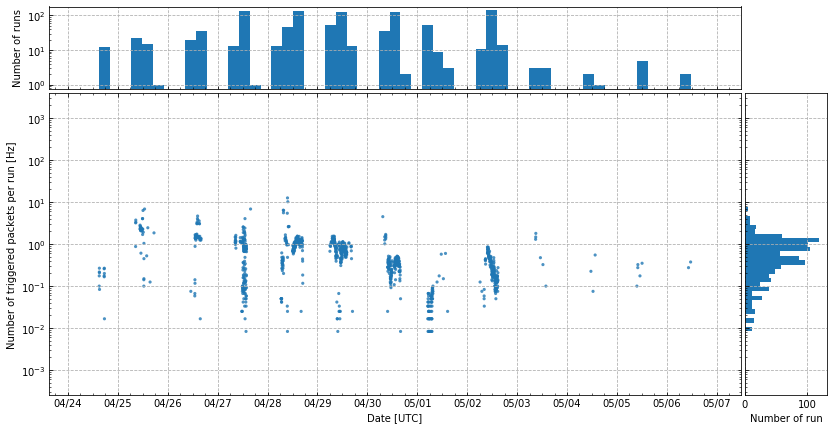

In [40]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf1_no_flatmap_key + '_trg_rate_1_per_packet')
);

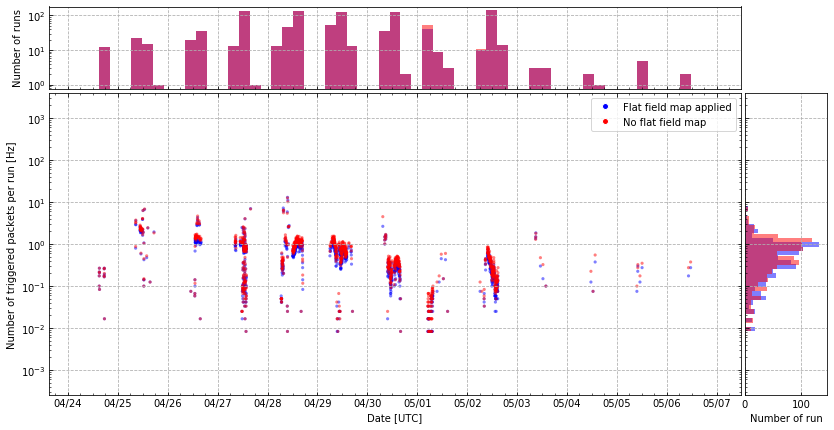

In [41]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_with_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='Flat field map applied', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='No flat field map',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('unl_flight_flatmap_comparison_l1trg_bgf1_flatmap_yes_no_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True,
    show=True
);

## Hardware data

In [42]:
hw_data_key = 'hw_trg'

In [43]:
# def filter_func(f,d): 
#     r = os.path.splitext(f)[1] == ".root" and "ACQUISITION" in os.path.basename(f) and re.search(r'SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170(42[4-9]|430|5\d+)$',d) is not None
#     return r

# processed_files = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(files_dir_abspath) for f in fn if filter_func(f,dp)])

# otgpp_file_trigger_datetime_list, otgpp_file_timedelta_list, otgpp_file_trigger_p_r_list, otgpp_trigger_num_per_file_list, otgpp_file_trigger_rate_list, otgpp_file_indices_list, \
# otgpp_trigger_num_per_file_list_pathname, otgpp_trigger_rate_per_file_list_pathname, otgpp_file_trigger_datetimes_list_pathname, \
# otgpp_file_trigger_p_r_list_pathname, otgpp_file_trigger_timedelta_list_pathname, otgpp_file_indices_list_pathname = \
#     count_trigger_rate_per_file(
#         processed_files, 
#         file_name_prefix='hw', trg_type='hw', one_trg_per_packet=True, 
#         data_snippets_dir=data_snippets_dir, return_filenames=True
#     )

loading data generated by trigger_rate_for_l1trg 

In [44]:
!cat trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_info.txt                

processed_files_hash = 2feee3b0332fbd7fea6241885d90f2aa
trigger_num_per_file_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl
trigger_rate_per_file_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl
file_trigger_datetimes_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl
file_trigger_p_r_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl
file_trigger_timedelta_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl
file_indices_list_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl
info_pathname = trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2a

In [45]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('trigger_rate_for_l1trg/hw_trg2feee3b0332fbd7fea6241885d90f2aa_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[hw_data_key] = {'lists_df': df}

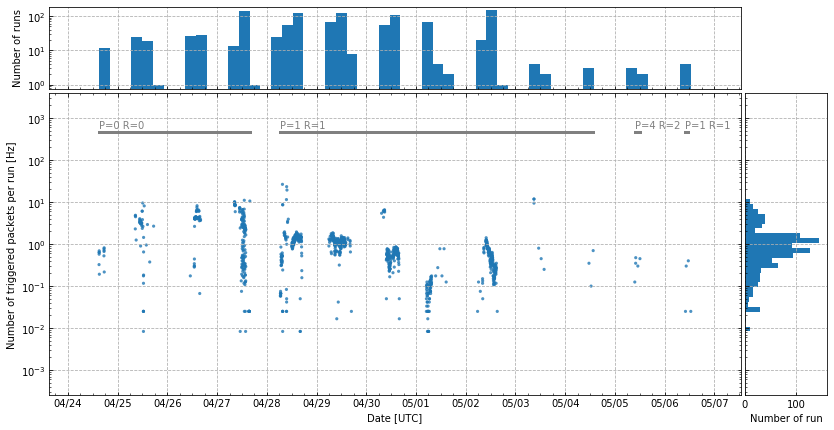

In [46]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path('hw_trg_rate_1_per_packet')
);

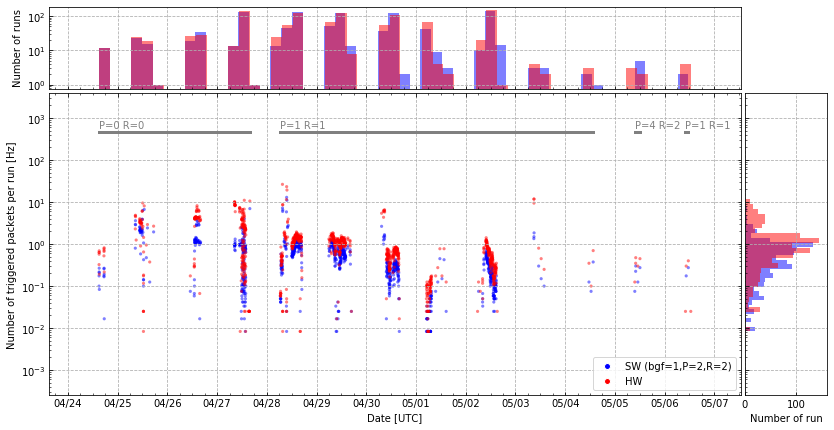

In [47]:
plt.close('all')
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'], 
        DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'], 
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (bgf=1,P=2,R=2)', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='HW',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('comparison_db_bgf1_p2r2_and_hw_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

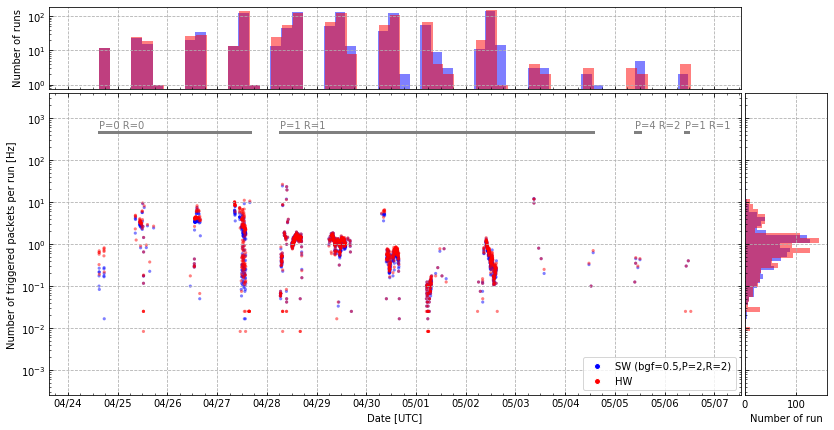

In [48]:
plt.close('all')
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_datetime_list'], 
        DATASETS_DICT[unl_flight_flatmap_bgf05_key]['trigger_rate_list'], 
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (bgf=0.5,P=2,R=2)', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='HW',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('comparison_db_bgf05_p2r2_and_hw_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

## Trigger rates from l1trg (TrigVisKenji) with various $P$, $R$ configurations (from node15)
<big>Presently not entirely valid</big>

### $P=1$, $R=1$, $\textrm{bgf}=1$  without flat field map 

In [49]:
l1trg_files_bgf1_p1r1_no_flatmap_key = 'l1trg_files_bgf1_p1r1_no_flatmap'

In [50]:
#!cat trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_info.txt

In [51]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p1r1_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key] = {'lists_df': df}

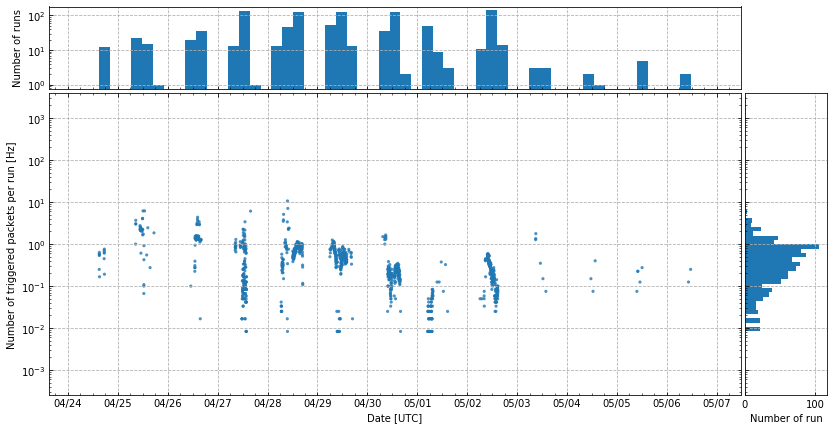

In [52]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf1_p1r1_no_flatmap_key + '_trg_rate_1_per_packet')
);

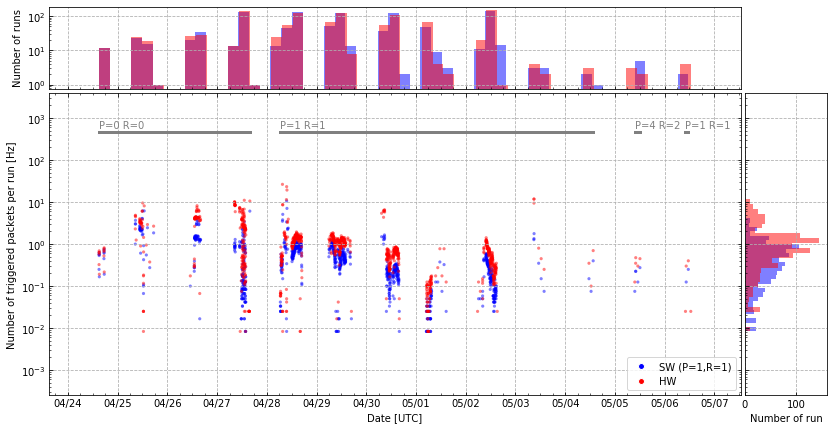

In [53]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=1,R=1)', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='HW',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('comparison_db_bgf1_p1r1_and_hw_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

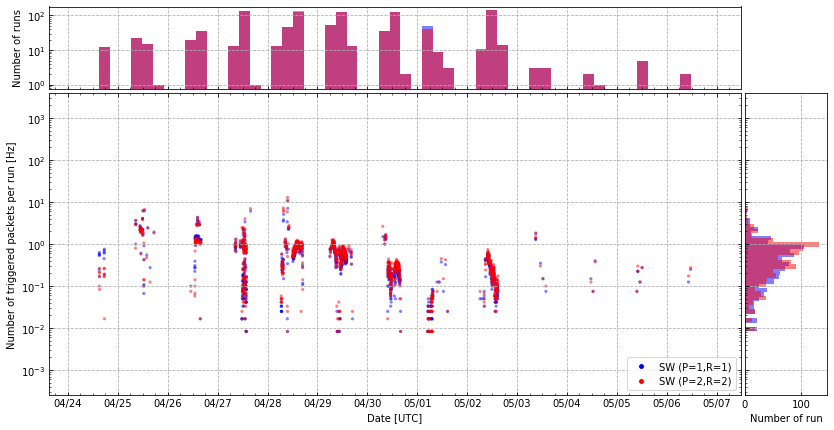

In [54]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=1,R=1)', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )


vis_trigger_rate_w_distributions(
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_datetime_list'], 
    DATASETS_DICT[unl_flight_flatmap_bgf1_key]['trigger_rate_list'], 
    ylim=(10**(-2.5), 10**(2.5)), 
    label='SW (P=2,R=2)',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('comparison_db_bgf1_p1r1_and_bgf1_p2r2_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

### $P=4$, $R=2$, $\textrm{bgf}=1$  without flat field map 

In [55]:
l1trg_files_bgf1_p4r2_no_flatmap_key = 'l1trg_files_bgf1_p4r2_no_flatmap'

In [56]:
#!cat trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_info.txt

In [57]:
df = pd.DataFrame()
df['trigger_num_per_file'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_trigger_num_per_file.pkl')
df['trigger_rate_per_file'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_trigger_rate_per_file.pkl')
df['file_trigger_datetimes'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_datetimes.pkl')
df['file_trigger_p_r'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_p_r.pkl')
df['file_trigger_timedelta'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_trigger_timedelta.pkl')
df['file_indices'] = joblib.load('node15/trigger_rate_for_l1trg/bg1p4r2_no_flatmapf57b7fcddde3b2444cd0e3e579e47ebf_one_trg_per_packet_128_file_indices.pkl')

DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key] = {'lists_df': df}

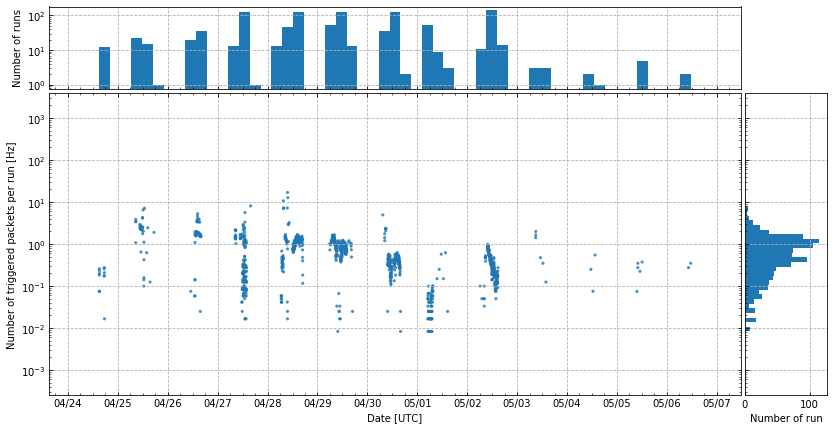

In [58]:
vis_trigger_rate_w_distributions(
    DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)),
    base_figure_pathname=fig_path(l1trg_files_bgf1_p4r2_no_flatmap_key + '_trg_rate_1_per_packet')
);

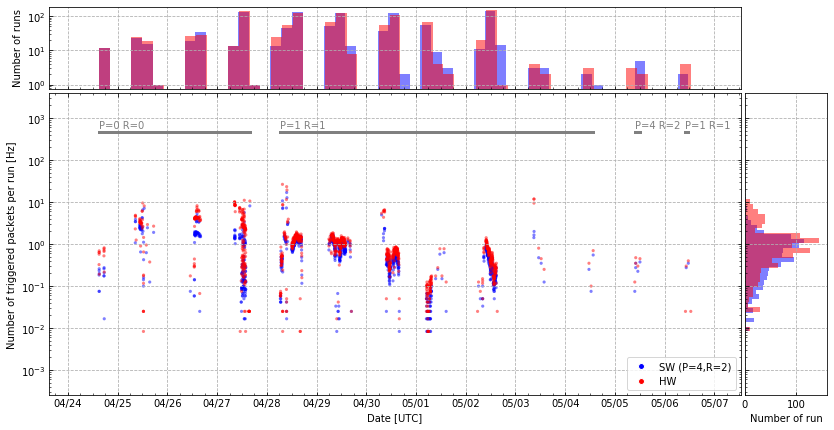

In [59]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=4,R=2)', color='blue', hist_alpha=.5, scatter_alpha=.5,
        show=False
    )

vis_trigger_rate_w_distributions(
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
    DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
    DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
    ylim=(10**(-2.5), 10**(2.5)), 
    label='HW',color='red', hist_alpha=.5, scatter_alpha=.5,
    base_figure_pathname=fig_path('comparison_db_bgf1_p4r2_and_hw_trg_rate_1_per_packet'),
    ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
    legend=True, legend_kwargs={'loc': 'lower right'},
    show=True
);

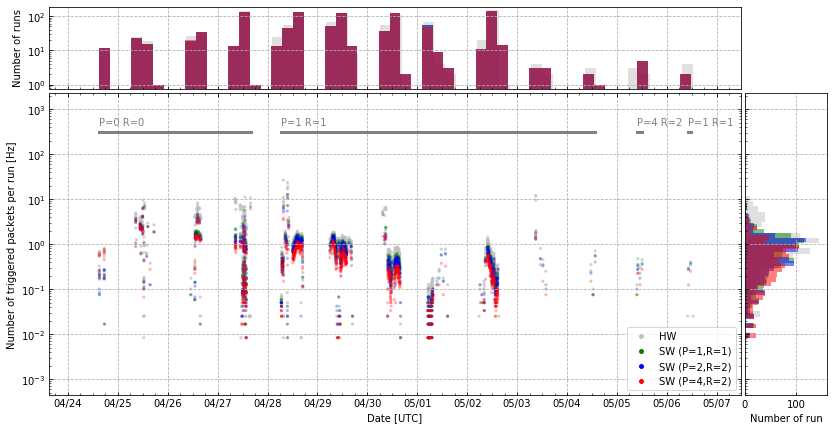

In [111]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
        DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
        ylim=(10**(-2.5), 10**(2.5)),
        label='HW', color='silver', hist_alpha=.5, scatter_alpha=.7,
        show=False
    )

fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=1,R=1)', color='green', hist_alpha=.5, scatter_alpha=.3,
        show=False
    )

fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=2,R=2)', color='blue', hist_alpha=.5, scatter_alpha=.3,
        show=False
    )

vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(10**(-2.5), 10**(2.5)), 
        label='SW (P=4,R=2)',color='red', hist_alpha=.5, scatter_alpha=.3,
        base_figure_pathname=fig_path('comparison_db_bgf1_p4r2_p2r2_p1r1_hw_trg_rate_1_per_packet_log'),
        legend=True, #legend_kwargs={'loc': 'lower right'},
        show=True
);

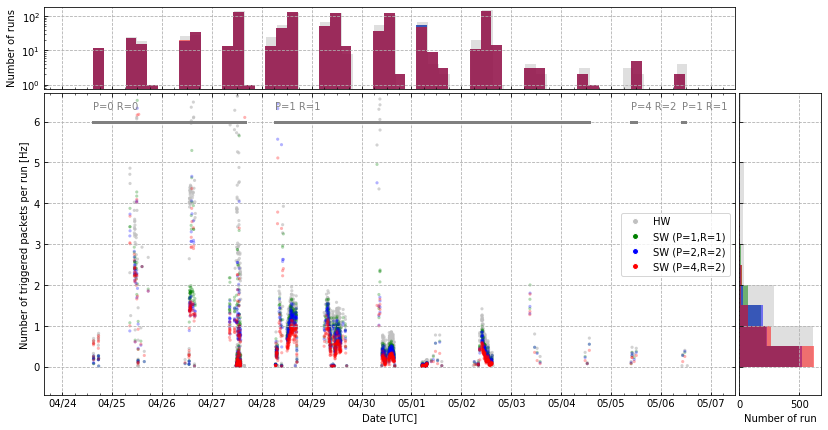

In [107]:
fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[hw_data_key]['lists_df']['trigger_rate_per_file'].tolist(),
        DATASETS_DICT[hw_data_key]['lists_df']['file_trigger_p_r'].tolist(),
        ylim=(0,6), #(10**(-2.5), 10**(2.5)),
        label='HW', color='silver', hist_alpha=.5, scatter_alpha=.7,
        vis_trigger_rate_kwargs={'yscale':'linear', 'padding_fraction': .1},
        trigger_rate_hist_kwargs={'values_scale':'linear'},
        show=False
    )

fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p4r2_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(0,6),#ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=1,R=1)', color='green', hist_alpha=.5, scatter_alpha=.3,
        vis_trigger_rate_kwargs={'yscale':'linear'},
        trigger_rate_hist_kwargs={'values_scale':'linear'},
        show=False
    )

fig, ax_scatter, ax_histx, ax_histy = \
    vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(0,6),#ylim=(10**(-2.5), 10**(2.5)),
        label='SW (P=2,R=2)', color='blue', hist_alpha=.5, scatter_alpha=.3,
        vis_trigger_rate_kwargs={'yscale':'linear'},
        trigger_rate_hist_kwargs={'values_scale':'linear'},
        show=False
    )

vis_trigger_rate_w_distributions(
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['file_trigger_datetimes'].tolist(), 
        DATASETS_DICT[l1trg_files_bgf1_p1r1_no_flatmap_key]['lists_df']['trigger_rate_per_file'].tolist(),
        ax_scatter=ax_scatter, ax_histx=ax_histx, ax_histy=ax_histy,
        ylim=(0,6),#ylim=(10**(-2.5), 10**(2.5)), 
        label='SW (P=4,R=2)',color='red', hist_alpha=.5, scatter_alpha=.3,
        vis_trigger_rate_kwargs={'yscale':'linear'},
        trigger_rate_hist_kwargs={'values_scale':'linear'},
        base_figure_pathname=fig_path('comparison_db_bgf1_p4r2_p2r2_p1r1_hw_trg_rate_1_per_packet_linear'),
        legend=True, #legend_kwargs={'loc': 'lower right'},
        show=True
);